### Прогнозирование биологического ответа

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. 

Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. 

Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.


In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import hyperopt
from hyperopt import Trials, fmin, hp, tpe

import optuna
#import matplotlib.pyplot as plt
import seaborn as sns

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
# Загружаем данные
data = pd.read_csv('data/_train_sem09__1_.zip')

In [3]:
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Посмотрим на размерность данных
data.shape

(3751, 1777)

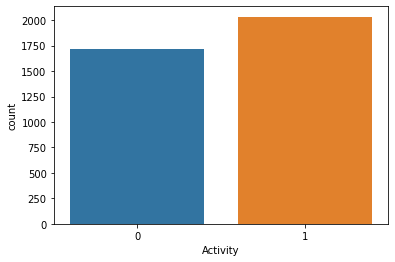

In [5]:
# Сбалансрованность классов
sns.countplot(data=data, x='Activity');

Классы сбалансированы

In [6]:
# Зафиксируем random_state
random_state = 42

In [7]:
# Создаем матрицу наблюдений X и вектор ответов y
X = data.drop(columns='Activity')
y = data['Activity']

# Разделяем выборки на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)

### Логистическая регрессия

In [8]:
# Значения гиперпараметров по умолчанию
# Создаем объект класса логистической регрессии
log_reg = linear_model.LogisticRegression(max_iter=1000)
# Обучаем модель
log_reg.fit(X_train, y_train)
print(f'accuracy Test: {log_reg.score(X_test, y_test):.3f}')
print(f'f1_score Test: {metrics.f1_score(y_test, log_reg.predict(X_test)):.3f}')


accuracy Test: 0.754
f1_score Test: 0.777


**GridSearchCV**

In [9]:
# Указываем гиперпараметры, которые будем тестировать
param_grid = {'penalty': ['l1','l2'],# тип регуляризации
              'solver': ['liblinear', 'saga'],# алгоритм оптимизации
              'C': list(np.linspace(0.01, 1, 10, dtype=float))
              }

# Инициируем объект класса GridSearchCV
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=random_state,
        max_iter=3000
    ),
    param_grid=param_grid, #сетка параметров
    cv=5, #количество фолдов для кросс-валидации
    n_jobs=-1 #используются все доступные ядра для расчетов
)

%time grid_search.fit(X_train, y_train)
print(f'accurasy Test: {grid_search.score(X_test, y_test):.3f}')
print(f'f1_score Test: {metrics.f1_score(y_test, grid_search.predict(X_test)):.3f}')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CPU times: user 1min 9s, sys: 993 ms, total: 1min 10s
Wall time: 44min 26s
accurasy Test: 0.754
f1_score Test: 0.781


In [10]:
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

Наилучшие значения гиперпараметров: {'C': 0.23, 'penalty': 'l1', 'solver': 'saga'}


метрика улучшилась

**RandomizedSearchCV**

In [11]:
# Указываем гиперпараметры, которые будем тестировать
param_distributions = {'penalty': ['l1', 'l2'],# тип регуляризации
              'solver': ['liblinear', 'saga'],# алгоритм оптимизации
              'C': list(np.linspace(0.01, 1, 10, dtype=float))
              }

# Инициируем объект класса RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=random_state,
        max_iter=3000
    ),
    param_distributions=param_distributions, #сетка параметров
    cv=5, #количество фолдов для кросс-валидации
    n_iter=10,
    n_jobs=-1 #используются все доступные ядра для расчетов
)

%time random_search.fit(X_train, y_train)
print(f'accurasy Test: {random_search.score(X_test, y_test):.3f}')
print(f'f1_score Test: {metrics.f1_score(y_test, random_search.predict(X_test)):.3f}')
print(f'Наилучшие значения гиперпараметров: {random_search.best_params_}')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CPU times: user 15.9 s, sys: 242 ms, total: 16.2 s
Wall time: 14min 47s
accurasy Test: 0.739
f1_score Test: 0.768
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.12}


значение метрики уменьшилось

**Hyperopt**

In [12]:
# задаем пространство поиска гиперпараметров
space = {'penalty': hp.choice('penalty', ['l1', 'l2']),
         'solver': hp.choice('solver', ['liblinear', 'saga']),
         'C': hp.quniform('C', 0.01, 1, 0.1)
}
# Создаем функцию для минимизации
def hyperopt_log_reg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в params
    params = {'penalty': params['penalty'],
              'solver': params['solver'],
              'C': params['C']
    }
    # Используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, max_iter=3000, random_state=random_state)
    
    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
    
    return -score
 
    

In [13]:
%%time
# Начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_log_reg, # наша функция
            space=space, # пространство гиперпараметров
            algo=tpe.suggest, #алгоритм оптимизации, установлен по умолчанию
            max_evals=10, # максимальное количество итераций
            trials=trials, #логирование результатов
            rstate=np.random.default_rng(random_state)) #фиксируем для повторяемости результата


print(f'Наилучшие значения гиперпараметров: {hyperopt.space_eval(space, best)}')

100%|██████████| 10/10 [10:37<00:00, 63.79s/trial, best loss: -0.7908077686739782]
Наилучшие значения гиперпараметров: {'C': 0.2, 'penalty': 'l1', 'solver': 'saga'}
CPU times: user 323 ms, sys: 243 ms, total: 566 ms
Wall time: 10min 37s


In [14]:
best_par = hyperopt.space_eval(space, best)
best_par

{'C': 0.2, 'penalty': 'l1', 'solver': 'saga'}

In [15]:
# Обучаем модель на подобранных параметрах
model = linear_model.LogisticRegression(
    random_state=random_state,
    max_iter=3000,
    C=best_par['C'],
    penalty=best_par['penalty'],
    solver=best_par['solver']
)
model.fit(X_train, y_train)
# Делаем предсказание, считаем метрики
y_test_pred = model.predict(X_test)
print(f'accuracy Test: {model.score(X_test, y_test):.3f}')
print(f'f1_score Test: {metrics.f1_score(y_test, y_test_pred):.3f}')


accuracy Test: 0.754
f1_score Test: 0.781


Метрика улучшилась

**Optuna**

In [16]:
%%time
# Настроим оптимизацию гиперпараметров для логистической регрессии
def optuna_log_reg(trial):
    # Задаем пространство поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    C = trial.suggest_float(name='C', low=0.01, high=0.51, step=0.1)
    
    # Создаем модель
    model = linear_model.LogisticRegression(penalty=penalty,
                                            solver=solver,
                                            C=C, 
                                            random_state=random_state,
                                            max_iter=3000)
    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(model, X, y, cv=5, scoring='f1', n_jobs=-1).mean()
    
    return score

study = optuna.create_study(study_name='LogisticRegression', direction='maximize')
# Ищем лучшую оптимизацию гиперпараметров
study.optimize(optuna_log_reg, n_trials=20)

# Выводим результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров: {study.best_params}')
print(f'f1_score Train: {study.best_value}')

#  Обучим модель с полученными параметрами
model = linear_model.LogisticRegression(**study.best_params, max_iter=3000, random_state=random_state)
model.fit(X_test, y_test)
y_test_pred = model.predict(X_test)
print(f'accuracy Test: {model.score(X_test, y_test):.3f}')
print(f'f1_score Test: {metrics.f1_score(y_test, y_test_pred)}')

[I 2023-05-07 15:55:03,673] A new study created in memory with name: LogisticRegression
[I 2023-05-07 15:55:41,059] Trial 0 finished with value: 0.7806068023495534 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.21000000000000002}. Best is trial 0 with value: 0.7806068023495534.
[I 2023-05-07 15:55:42,157] Trial 1 finished with value: 0.7882790117391154 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.21000000000000002}. Best is trial 1 with value: 0.7882790117391154.
[I 2023-05-07 16:00:54,532] Trial 2 finished with value: 0.7824342710055631 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.51}. Best is trial 1 with value: 0.7882790117391154.
[I 2023-05-07 16:01:37,097] Trial 3 finished with value: 0.7832607763390209 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.11}. Best is trial 1 with value: 0.7882790117391154.
[I 2023-05-07 16:01:57,242] Trial 4 finished with value: 0.7838901806138469 and parameters: {'penalty': 'l2', 'solver': 'saga

Наилучшие значения гиперпараметров: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.21000000000000002}
f1_score Train: 0.7882790117391154
accuracy Test: 0.794
f1_score Test: 0.8143712574850299
CPU times: user 816 ms, sys: 669 ms, total: 1.49 s
Wall time: 14min 13s


метрика улучшилась

In [17]:
optuna.visualization.plot_optimization_history(study, target_name='f1_score')

In [18]:
optuna.visualization.plot_param_importances(study, target_name='f1_score')

### RandomForest

**Baseline**

In [21]:
%%time
# Создаем объект RandomForestClassifier
rf = ensemble.RandomForestClassifier(random_state=random_state)
# Обучаем модель
rf.fit(X_train, y_train)
# Делаем предсказания
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
# Выводим метрики
print(f'f1_score Train: {metrics.f1_score(y_train, y_train_pred):.3f}')
print(f'accuracy Test: {metrics.accuracy_score(y_test, y_test_pred):.3f}')
print(f'f1_score Test: {metrics.f1_score(y_test, y_test_pred):.3f}')

f1_score Train: 1.000
accuracy Test: 0.786
f1_score Test: 0.805
CPU times: user 1.64 s, sys: 85.3 ms, total: 1.72 s
Wall time: 2.1 s


**GridSearchCV**

In [22]:
%%time
param_grid = {'n_estimators': list(range(80, 200, 30)),
                       'min_samples_leaf': [5],
                       'max_depth': list(np.linspace(20, 40, 10, dtype=int))
                       }


grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
    )

grid_search_forest.fit(X_train, y_train)
print(f'accurasy Train: {grid_search_forest.score(X_train, y_train):.3f}')
print(f'accurasy Test: {grid_search_forest.score(X_test, y_test):.3f}')
print(f'f1_score Test: {metrics.f1_score(y_test, grid_search_forest.predict(X_test)):.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_forest.best_params_}')
                    

accurasy Train: 0.940
accurasy Test: 0.783
f1_score Test: 0.803
Наилучшие значения гиперпараметров: {'max_depth': 22, 'min_samples_leaf': 5, 'n_estimators': 170}
CPU times: user 3.07 s, sys: 187 ms, total: 3.26 s
Wall time: 2min 31s


метрика слегка ухудшилась, уменьшилось переобучение

**RandomizedSearchCV**

In [23]:
%%time
param_distributions = {'n_estimators': list(range(80, 200, 30)),
                       'min_samples_leaf': [5],
                       'max_depth': list(np.linspace(20, 70, 10, dtype=int))
                       }


random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_distributions=param_distributions,
    cv=5,
    n_iter=10,
    n_jobs=-1
)

random_search_forest.fit(X_train, y_train)
print(f'accurasy Train: {random_search_forest.score(X_train, y_train):.3f}')
print(f'accurasy Test: {random_search_forest.score(X_test, y_test):.3f}')
print(f'f1_score Test: {metrics.f1_score(y_test, random_search_forest.predict(X_test)):.3f}')
print(f'Наилучшие значения гиперпараметров: {random_search_forest.best_params_}')
                    

accurasy Train: 0.940
accurasy Test: 0.788
f1_score Test: 0.808
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 53}
CPU times: user 2.43 s, sys: 86.8 ms, total: 2.52 s
Wall time: 33.3 s


In [24]:
%%time
param_distributions = {'n_estimators': list(range(80, 200, 30)),
                       'min_samples_leaf': [5],
                       'max_depth': list(np.linspace(20, 70, 10, dtype=int))
                       }


random_search_forest_1 = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_distributions=param_distributions,
    cv=5,
    n_iter=30,
    n_jobs=-1
)

random_search_forest_1.fit(X_train, y_train)
print(f'accurasy Train: {random_search_forest_1.score(X_train, y_train):.3f}')
print(f'accurasy Test: {random_search_forest_1.score(X_test, y_test):.3f}')
print(f'f1_score Test: {metrics.f1_score(y_test, random_search_forest_1.predict(X_test)):.3f}')
print(f'Наилучшие значения гиперпараметров: {random_search_forest_1.best_params_}')
                    

accurasy Train: 0.940
accurasy Test: 0.788
f1_score Test: 0.808
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 36}
CPU times: user 2.79 s, sys: 137 ms, total: 2.92 s
Wall time: 1min 43s


метрика улучшилась, увеличение кол-ва итераций не улучшило результат

**Hyperopt**

In [25]:
%%time
# Задаем пространство поиска гиперпараметров
space = {'n_estimators': hp.quniform(label='n_estimators', low=100, high=200, q=1),
         'max_depth': hp.quniform(label='max_depth', low=15, high=30, q=1),
         'min_samples_leaf': hp.quniform(label='min_samples_leaf', low=2, high=10, q=1)
         }

# Создаем функцию для минимизации
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # Функция получает комбинацию гиперпараметров в params
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])                 
              }
    # Используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    
    # Обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    return -score


CPU times: user 267 µs, sys: 226 µs, total: 493 µs
Wall time: 510 µs


In [26]:
%%time
# Начинаем подбор гиперпараметров
trials_rf = Trials() # используется для логирования результатов

best_rf = fmin(hyperopt_rf, # наша функция
               space=space, # пространство гиперпараметров
               algo=tpe.suggest, #алгоритм оптимизации, установлен по умолчанию
               max_evals=50, # максимальное количество итераций
               trials=trials_rf, #логирование результатов
               rstate=np.random.default_rng(random_state) #фиксируем для повторяемости результата
               )

print(f'Наилучшие значения гиперпараметров: {best_rf}')

100%|██████████| 50/50 [01:51<00:00,  2.24s/trial, best loss: -0.99079754601227]  
Наилучшие значения гиперпараметров: {'max_depth': 29.0, 'min_samples_leaf': 2.0, 'n_estimators': 167.0}
CPU times: user 1min 41s, sys: 2.51 s, total: 1min 44s
Wall time: 1min 51s


In [27]:
# Обучаем модель на подобранных параметрах
model = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf'])
)
model.fit(X_train, y_train)
# Делаем предсказание, считаем метрики
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print(f'f1_score на обучающем наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'accuracy на тестовом наборе: {model.score(X_test, y_test):.2f}')
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')


f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


Метрика улучшилась, но увеличилось переобучение

**Optuna**

In [28]:
%%time
# Настроим оптимизацию гиперпараметров
def optuna_rf(trial_rf):
    # Задаем пространство поиска гиперпараметров
    n_estimators = trial_rf.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial_rf.suggest_int('max_depth', 15, 30, 1)
    min_samples_leaf = trial_rf.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=random_state)
    # Обучаем модель, применяем кросс-валидацию
    score = cross_val_score(model, X, y, cv=5, scoring='f1', n_jobs=-1).mean()
    
    return score


study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
# Ищем лучшую оптимизацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

# Выводим результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров: {study.best_params}')
print(f'f1_score Train: {study.best_value}')

#  Обучим модель с полученными параметрами
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)
model.fit(X_test, y_test)
y_test_pred = model.predict(X_test)
print(f'accuracy Test: {model.score(X_test, y_test):.3f}')
print(f'f1_score Test: {metrics.f1_score(y_test, y_test_pred)}')   

[I 2023-05-07 14:36:07,238] A new study created in memory with name: RandomForestClassifier
[I 2023-05-07 14:36:12,458] Trial 0 finished with value: 0.8052062492973638 and parameters: {'n_estimators': 134, 'max_depth': 30, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8052062492973638.
[I 2023-05-07 14:36:16,610] Trial 1 finished with value: 0.7966218024699645 and parameters: {'n_estimators': 112, 'max_depth': 15, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8052062492973638.
[I 2023-05-07 14:36:23,013] Trial 2 finished with value: 0.7964347023444869 and parameters: {'n_estimators': 191, 'max_depth': 17, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8052062492973638.
[I 2023-05-07 14:36:27,446] Trial 3 finished with value: 0.8050942148278594 and parameters: {'n_estimators': 105, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8052062492973638.
[I 2023-05-07 14:36:33,119] Trial 4 finished with value: 0.805231147724092 and parameters: {'n_

Наилучшие значения гиперпараметров: {'n_estimators': 175, 'max_depth': 21, 'min_samples_leaf': 2}
f1_score Train: 0.8149939720600801
accuracy Test: 0.997
f1_score Test: 0.9975490196078431
CPU times: user 2.88 s, sys: 1.36 s, total: 4.24 s
Wall time: 5min 41s


мне кажется, получились каки-то нереальные значения: f1_score в тестовой выборке почти равна 1 и выше, чем на тестовой. Точность также пракически 1